# 微分幾何的にフラットなパラメータ表現を用いたVAE

+ フラットなパラメータを用いたparameterizationのための方法が無い！
+ KLDの計算が複雑になってしまう！
+ 数値計算的に不安定になる！ ＜＝ 割り算が出てきてしまう

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# ハイパーパラメータ
batch_size = 128
latent_dim = 2
epochs = 50
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


In [26]:
# MNISTデータセットの読み込みとデータローダーの作成
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



In [27]:
# VAEモデルの定義（フラットなパラメータ表現を使用）
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*32, 256),
            nn.ReLU()
        )
        self.fc_theta1 = nn.Linear(256, latent_dim)
        self.fc_theta2 = nn.Linear(256, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 7*7*32),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        theta1 = self.fc_theta1(h)
        theta2 = self.fc_theta2(h)
        return theta1, theta2

    def reparameterize(self, theta1, theta2):
        mu = theta1 / (-2 * theta2)
        sigma = torch.sqrt(torch.abs(-1 / (2 * theta2)) + 1e-8)
        eps = torch.randn_like(mu)
        z = mu + eps * sigma
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        theta1, theta2 = self.encode(x)
        z = self.reparameterize(theta1, theta2)
#        print('z shape:', z.shape)
        x_recon = self.decode(z)
        return x_recon, theta1, theta2



Epoch 1, Loss: 113.6695
Epoch 2, Loss: 114.2973
Epoch 3, Loss: 114.2105
Epoch 4, Loss: 114.1108
Epoch 5, Loss: 113.9912
Epoch 6, Loss: 113.8352
Epoch 7, Loss: 113.5802
Epoch 8, Loss: 113.0499
Epoch 9, Loss: 115.2069
Epoch 10, Loss: 116.4804
Epoch 11, Loss: 116.4218
Epoch 12, Loss: 116.3591
Epoch 13, Loss: 116.2915
Epoch 14, Loss: 116.2184
Epoch 15, Loss: 116.1386
Epoch 16, Loss: 116.0503
Epoch 17, Loss: 115.9516
Epoch 18, Loss: 115.8385
Epoch 19, Loss: 115.7053
Epoch 20, Loss: 115.5412
Epoch 21, Loss: 115.3559
Epoch 22, Loss: 115.1596
Epoch 23, Loss: 114.8913
Epoch 24, Loss: 114.4290
Epoch 25, Loss: 112.7803
Epoch 26, Loss: 103.6956
Epoch 27, Loss: 102.8236
Epoch 28, Loss: 102.8228
Epoch 29, Loss: 102.8222
Epoch 30, Loss: 102.8216
Epoch 31, Loss: 102.8209
Epoch 32, Loss: 102.8203
Epoch 33, Loss: 102.8197
Epoch 34, Loss: 102.8192
Epoch 35, Loss: 102.8186
Epoch 36, Loss: 102.8181
Epoch 37, Loss: 102.8176
Epoch 38, Loss: 102.8170
Epoch 39, Loss: 102.8165
Epoch 40, Loss: 102.8159
Epoch 41,

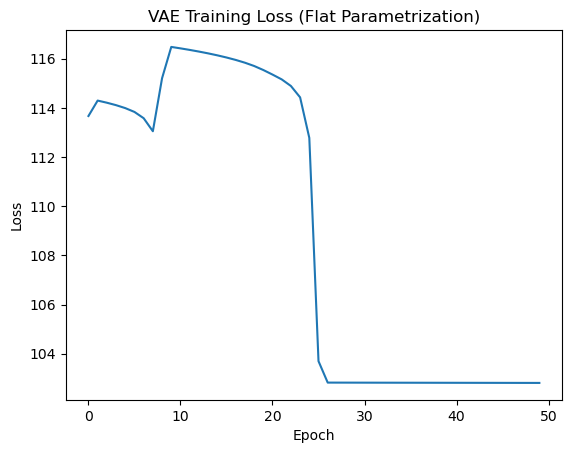

In [ ]:
# モデル、損失関数、最適化手法の定義
model = VAE(latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

def loss_function(recon_x, x, theta1, theta2):
#    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    MSE = nn.functional.mse_loss(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    # フラットなパラメータを用いたKLダイバージェンスの計算
    kld = 0.5 * torch.sum(torch.log(torch.abs(-2 * theta2) + 1e-8) + 1 / (2 * theta2) + (theta1 ** 2) / (4 * (theta2 ** 2)) - 1)
    return MSE + kld

# 学習ループ
train_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, theta1, theta2 = model(data)
        loss = loss_function(recon_batch, data, theta1, theta2)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader.dataset))
    print(f'Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}')

# 学習曲線のプロット
plt.plot(train_losses)
plt.title('VAE Training Loss (Flat Parametrization)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



(60000, 2)


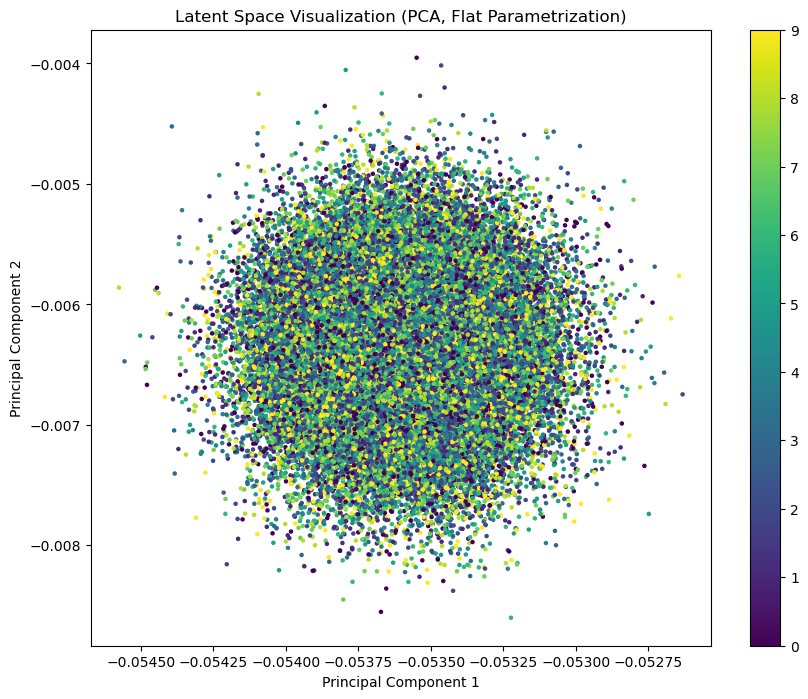

In [29]:
# 中間層の出力の可視化 (PCA適用)
model.eval()
z_list = []
labels_list = []
with torch.no_grad():
    for data, labels in train_loader:
        theta1, theta2 = model.encode(data)
        z = model.reparameterize(theta1, theta2)
        z_list.extend(z.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
z_list = np.array(z_list)
labels_list = np.array(labels_list)

print(z_list.shape)

# PCAを用いた次元削減
#pca = PCA(n_components=2)
#z_pca = pca.fit_transform(z_list)

plt.figure(figsize=(10, 8))
plt.scatter(z_list[:, 0], z_list[:, 1], c=labels_list, cmap='viridis', s=5)
plt.colorbar()
plt.title('Latent Space Visualization (PCA, Flat Parametrization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



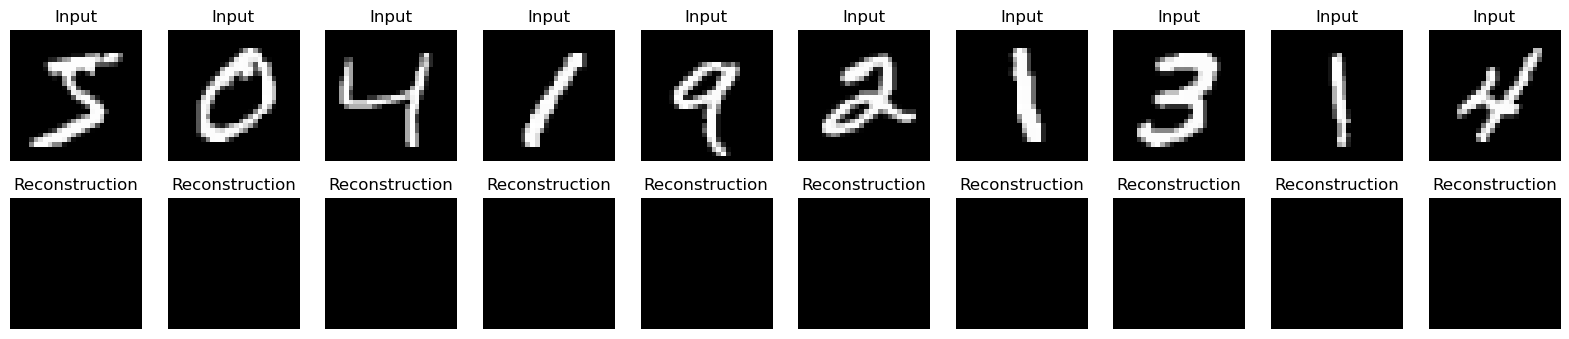

In [30]:
# 入力画像と再構成画像の比較
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    with torch.no_grad():
        sample = train_dataset[i][0].unsqueeze(0)
        recon_sample, _, _ = model(sample)
    plt.subplot(2, n, i+1)
    plt.imshow(sample.squeeze().numpy(), cmap='gray')
    plt.title('Input')
    plt.axis('off')
    plt.subplot(2, n, i+n+1)
    plt.imshow(recon_sample.squeeze().numpy(), cmap='gray')
    plt.title('Reconstruction')
    plt.axis('off')
plt.show()